In this example, we train a model on the clock dataset:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from energy_model.api import EnergyModel
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import RandomizedSearchCV, HalvingRandomSearchCV
from scipy.stats import poisson, expon, beta

In [3]:
n_dim = 2

In [4]:
X = pd.read_csv("clock.csv", header=0, index_col=None)
X

,x,y
0,-1.260606,-0.000535
1,1.002662,-1.204463
2,-1.321710,-0.238404
3,0.762651,1.143736
4,-0.869301,1.350036
...,...,...
9995,0.727683,-1.128361
9996,-0.925200,0.966343
9997,1.255048,-0.153047
9998,-0.083234,1.226470


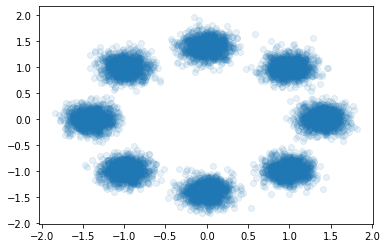

In [5]:
plt.scatter(X["x"], X["y"], alpha=0.1)

In [6]:
clf = EnergyModel(
    n_dim,
    batch_size=4096,
    num_layers=3,
    num_units=32,
    weight_decay=1e-2,
    max_iter=300,
    num_mc_steps=300,
    replay_prob=0.99,
    sampler="langevin",
    lr=1e-2,
    prior_scale=10
)
distributions = dict(
    lr=expon(1e-2),
    sampler_lr=expon(1e-1),
    sampler=["mala", "langevin", "tempered mala", "tempered langevin"],
    weight_decay=expon(1e-3),
#     max_iter=poisson(30),
    replay_prob=beta(a=9, b=1),
    num_units=poisson(32),
    num_layers=poisson(3),
    max_replay=poisson(10)
)
clf_cv = HalvingRandomSearchCV(clf, distributions, random_state=0, n_jobs=3, resource="max_iter", max_resources=300)
search = clf_cv.fit(X.values)

/Users/dlibland/miniconda3/envs/langevin_energy_model/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


on epoch 0, batch 0, data erf: -0.7535850405693054, objective: -0.8856887817382812
model energy: 7.499853134155273 +- 1.0806244611740112
data energy: 6.614164352416992
training time: 0.270s, metrics time: 0.000s
on epoch 0, batch 1, data erf: -0.9348698854446411, objective: -4.526242256164551
model energy: 11.836406707763672 +- 3.4706127643585205
data energy: 7.310164451599121
training time: 0.207s, metrics time: 0.000s
on epoch 0, batch 2, data erf: -0.9046697616577148, objective: -7.3660478591918945
model energy: 15.145214080810547 +- 6.245575904846191
data energy: 7.779166221618652
training time: 0.157s, metrics time: 0.000s
on epoch 0
avg_energy_grad: 0.005303513801967104
energy_grad_to_noise: 0.010506540354645509
avg_sample_distance: 2.7981872955958047
tempered_acceptance_ratio: 1.0
tempered_avg_sample_distance: 4.195272445678711
energy_coef: 0.45245789674874093
energy_diff: -4.259326299031575
data_erf: -0.8643748958905538
on epoch 1, batch 0, data erf: -0.8436105847358704, object

on epoch 9, batch 0, data erf: -0.7142544388771057, objective: -7.937093734741211
model energy: 21.330137252807617 +- 10.514972686767578
data energy: 13.393043518066406
training time: 0.216s, metrics time: 0.000s
on epoch 9, batch 1, data erf: -0.6907138824462891, objective: -7.463173866271973
model energy: 20.940467834472656 +- 10.380940437316895
data energy: 13.477293968200684
training time: 0.207s, metrics time: 0.000s
on epoch 9, batch 2, data erf: -0.6515619158744812, objective: -6.971673965454102
model energy: 20.489547729492188 +- 10.515350341796875
data energy: 13.517873764038086
training time: 0.153s, metrics time: 0.000s
on epoch 9
avg_energy_grad: 0.04387027335663637
energy_grad_to_noise: 0.050754450099803894
avg_sample_distance: 3.890615781148275
tempered_acceptance_ratio: 1.0
tempered_avg_sample_distance: 3.265155474344889
energy_coef: 0.23086902770347192
energy_diff: -7.457313855489095
data_erf: -0.6855100790659586
on epoch 10, batch 0, data erf: -0.6132596135139465, obje

on epoch 18, batch 0, data erf: -0.5532105565071106, objective: -4.332275390625
model energy: 16.699758529663086 +- 8.0532808303833
data energy: 12.367483139038086
training time: 0.236s, metrics time: 0.000s
on epoch 18, batch 1, data erf: -0.563872754573822, objective: -4.092395782470703
model energy: 16.467580795288086 +- 7.431813716888428
data energy: 12.375185012817383
training time: 0.213s, metrics time: 0.000s
on epoch 18, batch 2, data erf: -0.5699095129966736, objective: -4.517790794372559
model energy: 17.016462326049805 +- 8.097367286682129
data energy: 12.498671531677246
training time: 0.137s, metrics time: 0.000s
on epoch 18
avg_energy_grad: 0.03291325395305952
energy_grad_to_noise: 0.04011990479017875
avg_sample_distance: 3.3362491528193154
tempered_acceptance_ratio: 1.0
tempered_avg_sample_distance: 2.9254172643025718
energy_coef: 0.19035886501915122
energy_diff: -4.314153989156087
data_erf: -0.562330941359202
on epoch 19, batch 0, data erf: -0.5807982683181763, objective

on epoch 27, batch 0, data erf: -0.6568584442138672, objective: -4.275110244750977
model energy: 15.961250305175781 +- 6.377711296081543
data energy: 11.686140060424805
training time: 0.185s, metrics time: 0.000s
on epoch 27, batch 1, data erf: -0.646058976650238, objective: -4.523468017578125
model energy: 16.212909698486328 +- 6.901124954223633
data energy: 11.689441680908203
training time: 0.251s, metrics time: 0.000s
on epoch 27, batch 2, data erf: -0.6082584261894226, objective: -4.38414192199707
model energy: 16.15604591369629 +- 7.239203929901123
data energy: 11.771903991699219
training time: 0.175s, metrics time: 0.000s
on epoch 27
avg_energy_grad: 0.02695953504492839
energy_grad_to_noise: 0.03896786750908454
avg_sample_distance: 3.90921680132548
tempered_acceptance_ratio: 1.0
tempered_avg_sample_distance: 3.3088363806406655
energy_coef: 0.22119573833541387
energy_diff: -4.394240061442058
data_erf: -0.6370586156845093
on epoch 28, batch 0, data erf: -0.5676034688949585, objecti

on epoch 36, batch 0, data erf: -0.5990797877311707, objective: -4.896491050720215
model energy: 16.197526931762695 +- 8.243878364562988
data energy: 11.30103588104248
training time: 0.154s, metrics time: 0.000s
on epoch 36, batch 1, data erf: -0.579243540763855, objective: -4.353089332580566
model energy: 15.7503662109375 +- 7.64640998840332
data energy: 11.397276878356934
training time: 0.159s, metrics time: 0.000s
on epoch 36, batch 2, data erf: -0.5459634065628052, objective: -4.320677757263184
model energy: 15.899752616882324 +- 8.16126823425293
data energy: 11.57907485961914
training time: 0.139s, metrics time: 0.000s
on epoch 36
avg_energy_grad: 0.030985925967494648
energy_grad_to_noise: 0.040251946913409505
avg_sample_distance: 3.578606287638346
tempered_acceptance_ratio: 1.0
tempered_avg_sample_distance: 3.358684857686361
energy_coef: 0.2038933079027835
energy_diff: -4.523419380187988
data_erf: -0.574762245019277
on epoch 37, batch 0, data erf: -0.5388692617416382, objective: 

on epoch 45, batch 0, data erf: -0.5575233101844788, objective: -4.304839134216309
model energy: 15.406983375549316 +- 7.926851272583008
data energy: 11.102144241333008
training time: 0.203s, metrics time: 0.000s
on epoch 45, batch 1, data erf: -0.4921766519546509, objective: -4.329458236694336
model energy: 16.02219009399414 +- 9.245687484741211
data energy: 11.692731857299805
training time: 0.170s, metrics time: 0.000s
on epoch 45, batch 2, data erf: -0.5178419351577759, objective: -4.557465553283691
model energy: 17.049142837524414 +- 9.170319557189941
data energy: 12.491677284240723
training time: 0.130s, metrics time: 0.000s
on epoch 45
avg_energy_grad: 0.03386554059882959
energy_grad_to_noise: 0.041997584012772905
avg_sample_distance: 3.53516952196757
tempered_acceptance_ratio: 1.0
tempered_avg_sample_distance: 3.2132769425710044
energy_coef: 0.18652442831210173
energy_diff: -4.397254308064778
data_erf: -0.5225139657656351
on epoch 46, batch 0, data erf: -0.3825978636741638, obje

on epoch 54, batch 1, data erf: -0.5567559599876404, objective: -3.974802017211914
model energy: 16.35679817199707 +- 7.331450939178467
data energy: 12.381996154785156
training time: 0.187s, metrics time: 0.000s
on epoch 54, batch 2, data erf: -0.5285016298294067, objective: -4.131461143493652
model energy: 17.309349060058594 +- 8.114468574523926
data energy: 13.177887916564941
training time: 0.124s, metrics time: 0.000s
on epoch 54
avg_energy_grad: 0.030314094697435696
energy_grad_to_noise: 0.03924750673999709
avg_sample_distance: 3.511054277420044
tempered_acceptance_ratio: 1.0
tempered_avg_sample_distance: 3.1920088132222495
energy_coef: 0.18785382216140012
energy_diff: -3.904571851094564
data_erf: -0.5437243382136027
on epoch 55, batch 0, data erf: -0.3660077452659607, objective: -2.313070297241211
model energy: 16.00687599182129 +- 6.870553016662598
data energy: 13.693805694580078
training time: 0.166s, metrics time: 0.000s
on epoch 55, batch 1, data erf: -0.5675676465034485, obje

on epoch 63, batch 0, data erf: -0.34129270911216736, objective: -2.541508674621582
model energy: 16.079931259155273 +- 8.137304306030273
data energy: 13.538422584533691
training time: 0.196s, metrics time: 0.000s
on epoch 63, batch 1, data erf: -0.5639658570289612, objective: -3.5085325241088867
model energy: 14.447159767150879 +- 6.370222568511963
data energy: 10.938627243041992
training time: 0.195s, metrics time: 0.000s
on epoch 63, batch 2, data erf: -0.5918412804603577, objective: -3.8801231384277344
model energy: 14.665596961975098 +- 6.634106159210205
data energy: 10.785473823547363
training time: 0.150s, metrics time: 0.000s
on epoch 63
avg_energy_grad: 0.035022671024004616
energy_grad_to_noise: 0.04065177874294602
avg_sample_distance: 3.2473323742548623
tempered_acceptance_ratio: 1.0
tempered_avg_sample_distance: 2.932746966679891
energy_coef: 0.2044733788701971
energy_diff: -3.3100547790527344
data_erf: -0.4990332822004954
on epoch 64, batch 0, data erf: -0.6306218504905701,

on epoch 72, batch 0, data erf: -0.4005972445011139, objective: -2.840700149536133
model energy: 15.348474502563477 +- 7.648326396942139
data energy: 12.507774353027344
training time: 0.194s, metrics time: 0.000s
on epoch 72, batch 1, data erf: -0.5895864963531494, objective: -3.703343391418457
model energy: 14.258111953735352 +- 6.362407684326172
data energy: 10.554768562316895
training time: 0.165s, metrics time: 0.000s
on epoch 72, batch 2, data erf: -0.6373675465583801, objective: -4.032619476318359
model energy: 14.298649787902832 +- 6.264535427093506
data energy: 10.266030311584473
training time: 0.133s, metrics time: 0.000s
on epoch 72
avg_energy_grad: 0.031681763008236885
energy_grad_to_noise: 0.03980272394783765
avg_sample_distance: 3.4466717640558877
tempered_acceptance_ratio: 1.0
tempered_avg_sample_distance: 3.087496280670166
energy_coef: 0.206077479097216
energy_diff: -3.525554339090983
data_erf: -0.5425170958042145
on epoch 73, batch 0, data erf: -0.6630538702011108, obje

on epoch 81, batch 0, data erf: -0.5737863183021545, objective: -4.25588321685791
model energy: 15.305211067199707 +- 7.564185619354248
data energy: 11.049327850341797
training time: 0.148s, metrics time: 0.000s
on epoch 81, batch 1, data erf: -0.6254293322563171, objective: -4.569991111755371
model energy: 14.930168151855469 +- 7.278545379638672
data energy: 10.360177040100098
training time: 0.149s, metrics time: 0.000s
on epoch 81, batch 2, data erf: -0.6155765056610107, objective: -4.4545793533325195
model energy: 14.806904792785645 +- 7.2429399490356445
data energy: 10.352325439453125
training time: 0.111s, metrics time: 0.000s
on epoch 81
avg_energy_grad: 0.031540933375557266
energy_grad_to_noise: 0.040174372134759585
avg_sample_distance: 3.484888037045797
tempered_acceptance_ratio: 1.0
tempered_avg_sample_distance: 3.1207860310872397
energy_coef: 0.21945074984654264
energy_diff: -4.426817893981934
data_erf: -0.6049307187398275
on epoch 82, batch 0, data erf: -0.6666077375411987, 

on epoch 90, batch 0, data erf: -0.752272367477417, objective: -5.522096633911133
model energy: 16.35436248779297 +- 6.756221294403076
data energy: 10.832265853881836
training time: 0.158s, metrics time: 0.000s
on epoch 90, batch 1, data erf: -0.7658628225326538, objective: -5.79139518737793
model energy: 16.702436447143555 +- 6.883914947509766
data energy: 10.911041259765625
training time: 0.150s, metrics time: 0.000s
on epoch 90, batch 2, data erf: -0.7680687308311462, objective: -6.008441925048828
model energy: 17.14340591430664 +- 7.108272552490234
data energy: 11.134963989257812
training time: 0.123s, metrics time: 0.000s
on epoch 90
avg_energy_grad: 0.03143462724983692
energy_grad_to_noise: 0.04319468098013613
avg_sample_distance: 3.984127680460612
tempered_acceptance_ratio: 1.0
tempered_avg_sample_distance: 3.095246950785319
energy_coef: 0.2654335363419278
energy_diff: -5.773977915445964
data_erf: -0.762067973613739
on epoch 91, batch 0, data erf: -0.7942004203796387, objective:

on epoch 99, batch 0, data erf: -0.49271854758262634, objective: -4.056748390197754
model energy: 18.48487663269043 +- 8.652255058288574
data energy: 14.428128242492676
training time: 0.152s, metrics time: 0.000s
on epoch 99, batch 1, data erf: -0.5539675951004028, objective: -4.314780235290527
model energy: 16.94423484802246 +- 8.007415771484375
data energy: 12.629454612731934
training time: 0.149s, metrics time: 0.000s
on epoch 99, batch 2, data erf: -0.5968118906021118, objective: -4.856419563293457
model energy: 17.200531005859375 +- 8.215909004211426
data energy: 12.344111442565918
training time: 0.113s, metrics time: 0.000s
on epoch 99
avg_energy_grad: 0.03895443522681793
energy_grad_to_noise: 0.045528577366835334
avg_sample_distance: 3.5774023135503135
tempered_acceptance_ratio: 1.0
tempered_avg_sample_distance: 3.0292580127716064
energy_coef: 0.20391154956077384
energy_diff: -4.409316062927246
data_erf: -0.5478326777617136
on epoch 100, batch 0, data erf: -0.6302666664123535, o

on epoch 108, batch 1, data erf: -0.7476003170013428, objective: -4.87883186340332
model energy: 15.214377403259277 +- 6.0283684730529785
data energy: 10.335545539855957
training time: 0.167s, metrics time: 0.000s
on epoch 108, batch 2, data erf: -0.7614365220069885, objective: -4.788257598876953
model energy: 14.976737022399902 +- 5.745550155639648
data energy: 10.18847942352295
training time: 0.125s, metrics time: 0.000s
on epoch 108
avg_energy_grad: 0.026270858633021515
energy_grad_to_noise: 0.040029471359085994
avg_sample_distance: 4.1587967077891035
tempered_acceptance_ratio: 1.0
tempered_avg_sample_distance: 3.1482458114624023
energy_coef: 0.277642308154125
energy_diff: -4.684876124064128
data_erf: -0.7478240529696146
on epoch 109, batch 0, data erf: -0.7984794974327087, objective: -5.329841613769531
model energy: 15.579963684082031 +- 5.901462554931641
data energy: 10.2501220703125
training time: 0.174s, metrics time: 0.000s
on epoch 109, batch 1, data erf: -0.7981395125389099, 

on epoch 117, batch 1, data erf: -0.5052878856658936, objective: -3.834291458129883
model energy: 17.079008102416992 +- 7.94118595123291
data energy: 13.24471664428711
training time: 0.148s, metrics time: 0.000s
on epoch 117, batch 2, data erf: -0.4779230058193207, objective: -3.543942451477051
model energy: 16.48769187927246 +- 7.829281330108643
data energy: 12.94374942779541
training time: 0.113s, metrics time: 0.000s
on epoch 117
avg_energy_grad: 0.03322590421885252
energy_grad_to_noise: 0.04117174680848446
avg_sample_distance: 3.4816883405049643
tempered_acceptance_ratio: 1.0
tempered_avg_sample_distance: 3.302710930506388
energy_coef: 0.18745185049675758
energy_diff: -3.851569493611654
data_erf: -0.49012938141822815
on epoch 118, batch 0, data erf: -0.49940961599349976, objective: -3.3331546783447266
model energy: 16.123197555541992 +- 6.998314380645752
data energy: 12.790042877197266
training time: 0.149s, metrics time: 0.000s
on epoch 118, batch 1, data erf: -0.46511703729629517

on epoch 126, batch 1, data erf: -0.7055157423019409, objective: -4.958258628845215
model energy: 15.87549877166748 +- 6.6887359619140625
data energy: 10.917240142822266
training time: 0.150s, metrics time: 0.000s
on epoch 126, batch 2, data erf: -0.6770408153533936, objective: -4.963896751403809
model energy: 16.018672943115234 +- 7.102433204650879
data energy: 11.054776191711426
training time: 0.109s, metrics time: 0.000s
on epoch 126
avg_energy_grad: 0.025832544391353924
energy_grad_to_noise: 0.0379198062507214
avg_sample_distance: 3.8416362206141152
tempered_acceptance_ratio: 1.0
tempered_avg_sample_distance: 3.3764027754465737
energy_coef: 0.24463662535943934
energy_diff: -4.753654479980469
data_erf: -0.6806055307388306
on epoch 127, batch 0, data erf: -0.6851505637168884, objective: -4.8962602615356445
model energy: 16.204833984375 +- 6.889233112335205
data energy: 11.308573722839355
training time: 0.147s, metrics time: 0.000s
on epoch 127, batch 1, data erf: -0.6413277983665466,

on epoch 135, batch 0, data erf: -0.55739426612854, objective: -4.326666831970215
model energy: 16.57402992248535 +- 7.969297885894775
data energy: 12.247363090515137
training time: 0.206s, metrics time: 0.000s
on epoch 135, batch 1, data erf: -0.5267021656036377, objective: -4.19822883605957
model energy: 16.571401596069336 +- 8.279175758361816
data energy: 12.373172760009766
training time: 0.209s, metrics time: 0.000s
on epoch 135, batch 2, data erf: -0.5426955223083496, objective: -4.281153678894043
model energy: 16.78765106201172 +- 8.145465850830078
data energy: 12.506497383117676
training time: 0.129s, metrics time: 0.000s
on epoch 135
avg_energy_grad: 0.03037981657932202
energy_grad_to_noise: 0.038603416428720116
avg_sample_distance: 3.3807700077692666
tempered_acceptance_ratio: 1.0
tempered_avg_sample_distance: 3.0440831184387207
energy_coef: 0.19348230264408509
energy_diff: -4.268683115641276
data_erf: -0.5422639846801758
on epoch 136, batch 0, data erf: -0.521277129650116, ob

on epoch 144, batch 0, data erf: -0.3404177129268646, objective: -1.8007965087890625
model energy: 13.734679222106934 +- 5.781541347503662
data energy: 11.933882713317871
training time: 0.185s, metrics time: 0.000s
on epoch 144, batch 1, data erf: -0.5467976927757263, objective: -3.0981454849243164
model energy: 13.552183151245117 +- 5.841241836547852
data energy: 10.4540376663208
training time: 0.160s, metrics time: 0.000s
on epoch 144, batch 2, data erf: -0.5882468819618225, objective: -3.126011848449707
model energy: 13.489988327026367 +- 5.385942459106445
data energy: 10.36397647857666
training time: 0.125s, metrics time: 0.000s
on epoch 144
avg_energy_grad: 0.02967898330340783
energy_grad_to_noise: 0.03646101687337832
avg_sample_distance: 3.1453171173731485
tempered_acceptance_ratio: 1.0
tempered_avg_sample_distance: 2.8964246114095054
energy_coef: 0.21000211238623243
energy_diff: -2.674984614054362
data_erf: -0.4918207625548045
on epoch 145, batch 0, data erf: -0.6584601998329163

on epoch 153, batch 1, data erf: -0.5605717301368713, objective: -4.167593955993652
model energy: 15.331182479858398 +- 7.6230998039245605
data energy: 11.163588523864746
training time: 0.151s, metrics time: 0.000s
on epoch 153, batch 2, data erf: -0.6535824537277222, objective: -4.245145797729492
model energy: 15.230725288391113 +- 6.376160621643066
data energy: 10.985579490661621
training time: 0.120s, metrics time: 0.000s
on epoch 153
avg_energy_grad: 0.03369243505100409
energy_grad_to_noise: 0.041843060811345416
avg_sample_distance: 3.549642483393351
tempered_acceptance_ratio: 1.0
tempered_avg_sample_distance: 3.2499828338623047
energy_coef: 0.20869639501283385
energy_diff: -3.923091252644857
data_erf: -0.5523224174976349
on epoch 154, batch 0, data erf: -0.6607937216758728, objective: -4.661861419677734
model energy: 15.712578773498535 +- 6.898219108581543
data energy: 11.0507173538208
training time: 0.159s, metrics time: 0.000s
on epoch 154, batch 1, data erf: -0.6870180368423462

on epoch 162, batch 0, data erf: -0.7005446553230286, objective: -6.018289566040039
model energy: 17.854175567626953 +- 8.202707290649414
data energy: 11.835886001586914
training time: 0.162s, metrics time: 0.000s
on epoch 162, batch 1, data erf: -0.7882704734802246, objective: -6.801465034484863
model energy: 18.107362747192383 +- 7.7022271156311035
data energy: 11.30589771270752
training time: 0.160s, metrics time: 0.000s
on epoch 162, batch 2, data erf: -0.7941545248031616, objective: -7.6371307373046875
model energy: 19.188390731811523 +- 8.537485122680664
data energy: 11.551259994506836
training time: 0.159s, metrics time: 0.000s
on epoch 162
avg_energy_grad: 0.03945798923571905
energy_grad_to_noise: 0.05097608519909688
avg_sample_distance: 4.345387895901998
tempered_acceptance_ratio: 1.0
tempered_avg_sample_distance: 3.243767023086548
energy_coef: 0.2704162016232708
energy_diff: -6.81896177927653
data_erf: -0.7609898845354716
on epoch 163, batch 0, data erf: -0.8319093585014343, 

on epoch 171, batch 0, data erf: -0.5025185346603394, objective: -4.4085588455200195
model energy: 18.406644821166992 +- 9.189434051513672
data energy: 13.998085975646973
training time: 0.211s, metrics time: 0.000s
on epoch 171, batch 1, data erf: -0.4968157410621643, objective: -3.9004554748535156
model energy: 16.656679153442383 +- 8.23924732208252
data energy: 12.756223678588867
training time: 0.263s, metrics time: 0.000s
on epoch 171, batch 2, data erf: -0.6099094152450562, objective: -4.5079803466796875
model energy: 16.109060287475586 +- 7.417794704437256
data energy: 11.601079940795898
training time: 0.185s, metrics time: 0.000s
on epoch 171
avg_energy_grad: 0.03771390455464522
energy_grad_to_noise: 0.04384483677760446
avg_sample_distance: 3.484135945638021
tempered_acceptance_ratio: 1.0
tempered_avg_sample_distance: 3.006011962890625
energy_coef: 0.19726867887244004
energy_diff: -4.272331555684407
data_erf: -0.5364145636558533
on epoch 172, batch 0, data erf: -0.620160102844238

on epoch 180, batch 0, data erf: -0.6237459778785706, objective: -4.043855667114258
model energy: 15.324666023254395 +- 6.463325023651123
data energy: 11.280810356140137
training time: 0.214s, metrics time: 0.000s
on epoch 180, batch 1, data erf: -0.5118532180786133, objective: -4.366452217102051
model energy: 16.292875289916992 +- 8.90733814239502
data energy: 11.926423072814941
training time: 0.249s, metrics time: 0.000s
on epoch 180, batch 2, data erf: -0.5275416970252991, objective: -4.475417137145996
model energy: 17.20865249633789 +- 8.80908489227295
data energy: 12.733235359191895
training time: 0.182s, metrics time: 0.000s
on epoch 180
avg_energy_grad: 0.02961336572964986
energy_grad_to_noise: 0.038939829065402894
avg_sample_distance: 3.523824612299601
tempered_acceptance_ratio: 1.0
tempered_avg_sample_distance: 3.4630582332611084
energy_coef: 0.20012753262297053
energy_diff: -4.295241673787435
data_erf: -0.5543802976608276
on epoch 181, batch 0, data erf: -0.4081794023513794, 

on epoch 189, batch 0, data erf: -0.5694615840911865, objective: -5.707693099975586
model energy: 19.153934478759766 +- 10.240006446838379
data energy: 13.44624137878418
training time: 0.253s, metrics time: 0.000s
on epoch 189, batch 1, data erf: -0.568832278251648, objective: -4.208110809326172
model energy: 15.976228713989258 +- 7.559966087341309
data energy: 11.768117904663086
training time: 0.260s, metrics time: 0.000s
on epoch 189, batch 2, data erf: -0.7131403684616089, objective: -5.421666145324707
model energy: 16.17327880859375 +- 7.199187278747559
data energy: 10.751612663269043
training time: 0.188s, metrics time: 0.000s
on epoch 189
avg_energy_grad: 0.04230552352964878
energy_grad_to_noise: 0.0486053676230857
avg_sample_distance: 3.7467361291249595
tempered_acceptance_ratio: 1.0
tempered_avg_sample_distance: 3.1171422799428306
energy_coef: 0.2324920856605355
energy_diff: -5.112490018208821
data_erf: -0.6171447436014811
on epoch 190, batch 0, data erf: -0.7682095170021057, o

on epoch 198, batch 1, data erf: -0.49512380361557007, objective: -4.607911109924316
model energy: 19.751323699951172 +- 9.772356986999512
data energy: 15.143412590026855
training time: 0.166s, metrics time: 0.000s
on epoch 198, batch 2, data erf: -0.34432196617126465, objective: -2.0939340591430664
model energy: 16.997343063354492 +- 6.641283988952637
data energy: 14.903409004211426
training time: 0.122s, metrics time: 0.000s
on epoch 198
avg_energy_grad: 0.042566572626431785
energy_grad_to_noise: 0.046930397333409195
avg_sample_distance: 3.4906190633773804
tempered_acceptance_ratio: 1.0
tempered_avg_sample_distance: 3.1399243672688804
energy_coef: 0.19312198241350306
energy_diff: -3.7293675740559897
data_erf: -0.441689133644104
on epoch 199, batch 0, data erf: -0.5902425646781921, objective: -4.011326789855957
model energy: 17.4797420501709 +- 6.881877422332764
data energy: 13.468415260314941
training time: 0.152s, metrics time: 0.000s
on epoch 199, batch 1, data erf: -0.656778454780

on epoch 207, batch 0, data erf: -0.49285054206848145, objective: -3.7811384201049805
model energy: 16.780086517333984 +- 8.06192684173584
data energy: 12.998948097229004
training time: 0.148s, metrics time: 0.000s
on epoch 207, batch 1, data erf: -0.46132227778434753, objective: -3.2331905364990234
model energy: 16.011066436767578 +- 7.437084197998047
data energy: 12.777875900268555
training time: 0.148s, metrics time: 0.000s
on epoch 207, batch 2, data erf: -0.5111268758773804, objective: -3.3557348251342773
model energy: 15.654796600341797 +- 6.856971740722656
data energy: 12.29906177520752
training time: 0.114s, metrics time: 0.000s
on epoch 207
avg_energy_grad: 0.031033180343608063
energy_grad_to_noise: 0.03951944895158144
avg_sample_distance: 3.4696324666341147
tempered_acceptance_ratio: 1.0
tempered_avg_sample_distance: 3.1877928574879966
energy_coef: 0.19698638713621433
energy_diff: -3.4566879272460938
data_erf: -0.48843323191006977
on epoch 208, batch 0, data erf: -0.576611042

on epoch 216, batch 0, data erf: -0.44642430543899536, objective: -2.8438844680786133
model energy: 13.610567092895508 +- 6.788973808288574
data energy: 10.766682624816895
training time: 0.210s, metrics time: 0.000s
on epoch 216, batch 1, data erf: -0.5099626779556274, objective: -3.042724609375
model energy: 13.202569007873535 +- 6.234068870544434
data energy: 10.159844398498535
training time: 0.163s, metrics time: 0.000s
on epoch 216, batch 2, data erf: -0.5004371404647827, objective: -3.258657455444336
model energy: 13.114351272583008 +- 6.825517654418945
data energy: 9.855693817138672
training time: 0.109s, metrics time: 0.000s
on epoch 216
avg_energy_grad: 0.027737441162268322
energy_grad_to_noise: 0.035221511633323606
avg_sample_distance: 3.130222956339518
tempered_acceptance_ratio: 1.0
tempered_avg_sample_distance: 2.9871208667755127
energy_coef: 0.17797391942602292
energy_diff: -3.04842217763265
data_erf: -0.4856080412864685
on epoch 217, batch 0, data erf: -0.5475568175315857,

on epoch 225, batch 1, data erf: -0.5794070363044739, objective: -4.292119979858398
model energy: 15.186367988586426 +- 7.536661624908447
data energy: 10.894248008728027
training time: 0.173s, metrics time: 0.000s
on epoch 225, batch 2, data erf: -0.512914776802063, objective: -3.70151424407959
model energy: 15.223749160766602 +- 7.532505989074707
data energy: 11.522234916687012
training time: 0.123s, metrics time: 0.000s
on epoch 225
avg_energy_grad: 0.03110533735404412
energy_grad_to_noise: 0.04036991322087485
avg_sample_distance: 3.6218133767445884
tempered_acceptance_ratio: 1.0
tempered_avg_sample_distance: 3.152792056401571
energy_coef: 0.1955232828135057
energy_diff: -4.026165962219238
data_erf: -0.5473984479904175
on epoch 226, batch 0, data erf: -0.4569138288497925, objective: -2.6459598541259766
model energy: 13.450531005859375 +- 6.152980804443359
data energy: 10.804571151733398
training time: 0.150s, metrics time: 0.000s
on epoch 226, batch 1, data erf: -0.5697636604309082, 

on epoch 234, batch 0, data erf: -0.5897251963615417, objective: -4.104724884033203
model energy: 14.456886291503906 +- 7.049898624420166
data energy: 10.352161407470703
training time: 0.156s, metrics time: 0.000s
on epoch 234, batch 1, data erf: -0.5849494338035583, objective: -4.1776885986328125
model energy: 14.760200500488281 +- 7.2489190101623535
data energy: 10.582511901855469
training time: 0.149s, metrics time: 0.000s
on epoch 234, batch 2, data erf: -0.5421714782714844, objective: -4.068717956542969
model energy: 15.06186580657959 +- 7.750302791595459
data energy: 10.993147850036621
training time: 0.128s, metrics time: 0.000s
on epoch 234
avg_energy_grad: 0.027856432522336643
energy_grad_to_noise: 0.03713752514645529
avg_sample_distance: 3.432516892751058
tempered_acceptance_ratio: 1.0
tempered_avg_sample_distance: 3.202310641606649
energy_coef: 0.20431022094832652
energy_diff: -4.117043813069661
data_erf: -0.5722820361455282
on epoch 235, batch 0, data erf: -0.542418301105499

In [7]:
search.best_params_

{'lr': 0.1699356033545261,
 'max_replay': 10,
 'num_layers': 2,
 'num_units': 29,
 'replay_prob': 0.9601421170283363,
 'sampler': 'tempered langevin',
 'sampler_lr': 3.924569682207733,
 'weight_decay': 0.04810583902150315,
 'max_iter': 243}

In [8]:
search.best_params_

{'lr': 0.1699356033545261,
 'max_replay': 10,
 'num_layers': 2,
 'num_units': 29,
 'replay_prob': 0.9601421170283363,
 'sampler': 'tempered langevin',
 'sampler_lr': 3.924569682207733,
 'weight_decay': 0.04810583902150315,
 'max_iter': 243}

In [9]:
clf = clf_cv.best_estimator_

In [10]:
samples = clf.sample(1000)

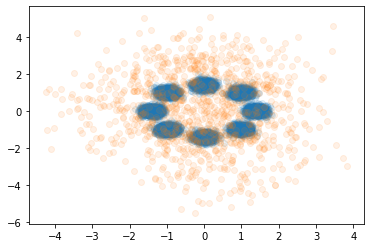

In [11]:
plt.scatter(X["x"], X["y"], alpha=0.1)
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1)

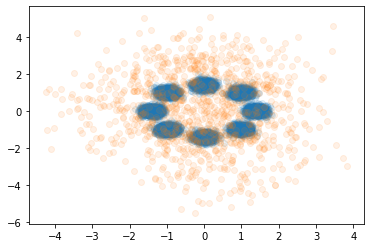

In [18]:
fig, ax = plt.subplots()
ax.scatter(X["x"], X["y"], alpha=0.1)
ax.scatter(samples[:, 0], samples[:, 1], alpha=0.1)

In [19]:
fig.savefig("clock.png")

In [13]:
cols = ["energy_diff", "energy_coef", "data_erf"]
logs = pd.DataFrame({k:v for k,v in clf.logger_.full_logs.items() if k in cols})

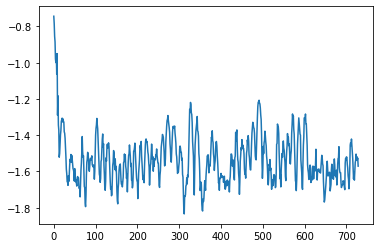

In [14]:
logs["energy_coef"].apply(np.log).plot()

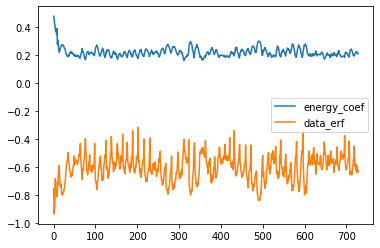

In [15]:
logs[[c for c in cols if c != "energy_diff"]].plot()

In [16]:
clf.logger_.full_logs.keys()

dict_keys(['avg_energy_grad', 'energy_grad_to_noise', 'avg_sample_distance', 'tempered_acceptance_ratio', 'tempered_avg_sample_distance', 'energy_coef', 'energy_diff', 'data_erf'])